This example applies the variational sparse coding model to the fashion-MNIST dataset

First, import what is needed

In [1]:
%matplotlib inline

import numpy as np
import scipy.io as sio
from models import VSC_model
import matplotlib.pyplot as plt

Load the fashion-MNIST training and test set

In [2]:
def get_Zalando_data(fn): # Function to load and normalise data set
    
    Xp = np.load(fn)
    Xs = np.shape(Xp)
    x_data = Xp.reshape(Xs[0],Xs[1]*Xs[2])
    
    l2norm = np.sqrt((x_data * x_data).sum(axis=1))
    x_data = x_data / l2norm.reshape(Xs[0],1)
    
    return x_data

# Load the Fashion-MNIST data set to test VSC with
x_data_train = get_Zalando_data("Data_Sets/Zalando_data/Zalando_train_images_large.npy") # Training set
x_data_test = get_Zalando_data("Data_Sets/Zalando_data/Zalando_test_images.npy") # Test set

Define the parameters of the model

In [3]:
def get_params(): # Define parameters
    params = dict(
        num_iterations=100000, # Number of totl iterations
        initial_training_rate=0.0005, # Initial training rate for ADAM optimiser
        batch_size=500, # Batch size
        report_interval=5000, # Interval of iterations at which to display and save values (ELBO, KL ecc.)
        z_dimension=60, # Latent space dimensionality
        h_enc_dim = 3000, # Number of hidden units between observation and latent space 
        h_dec_dim = 3000, # Number of hidden units between latent and observation space
        n_pinputs = 10, # Number of pseudo-inputs constituting the prior
        warm_up_start = 45000, # Number of iteration below which only discrete variables can be used (Spike warmup)
        warm_up_end = 50000, # Number of iteration above which both discrete and continuous variables can be used (Spike warmup)
        shorten_steps_it = 45000, # Iteration number after which to reduce the step size
        nu = 10, # Inverse "temperature" of sigmoid to be used for parametrising discrete variables (the higher the sharper)
        alpha = 0.01, # Overall sparsity to be encouraged in the aggregate posterior
    )
    return params

# Load the parameters
params = get_params()

Now the VSC model can be trained with the training images (This takes a while. There is saved weights already, but they can be re-trained by uncommenting below)

In [4]:
# Train the VSC model
# CF = VSC_model.train(x_data_train,params,"stored_weights/fashionMNIST_example/VSC_stored_weights.ckpt") # Save the trained weights and return the values of different functions (ELBO, KL ecc.)

Now we can encode the test set using the trained model

In [5]:
# Encode the test set using the trained model
z, z_act = VSC_model.encode(x_data_test,params,"stored_weights/fashionMNIST_example/VSC_stored_weights.ckpt") # Returns samples in the latent space and activations (Spike variables)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from stored_weights/fashionMNIST_example/VSC_stored_weights.ckpt


lienar_projections: 2019-06-14 13:31:39,748 - DEBUG - Initialised Graph


Load the test labels to check the average latent activation per class

In [6]:
lbl = np.load("Data_Sets/Zalando_data/Zalando_test_labels.npy")

Compute the average latent variable activation for each class, to see how different types of objects activate different latent variables.
Latent variables are on the x axis and classes are on the y axis.

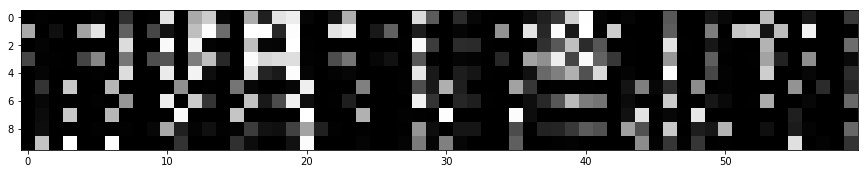

In [7]:
CA = np.zeros((10,np.shape(z_act)[1]))
for cl in range(10):
    
    z_act_cl = z_act[lbl==cl,:]
    z_act_tot_cl = np.mean(z_act_cl,axis=0)
    CA[cl,:] = z_act_tot_cl
    
plt.figure(figsize=(15, 6))
plt.imshow(CA, cmap="gray")

Decode the latent codes to generate the corresponding images.

In [8]:
# Reconstruct the images by decoding the latent codes
mu_x, sig_x = VSC_model.decode(z,np.shape(x_data_test),params,"stored_weights/fashionMNIST_example/VSC_stored_weights.ckpt") # Returns means and standard deviations of the reconstructed images

INFO:tensorflow:Restoring parameters from stored_weights/fashionMNIST_example/VSC_stored_weights.ckpt


lienar_projections: 2019-06-14 13:44:07,851 - DEBUG - Initialised Graph


plot some input images along with the corresponding latent codes and reconstructed images

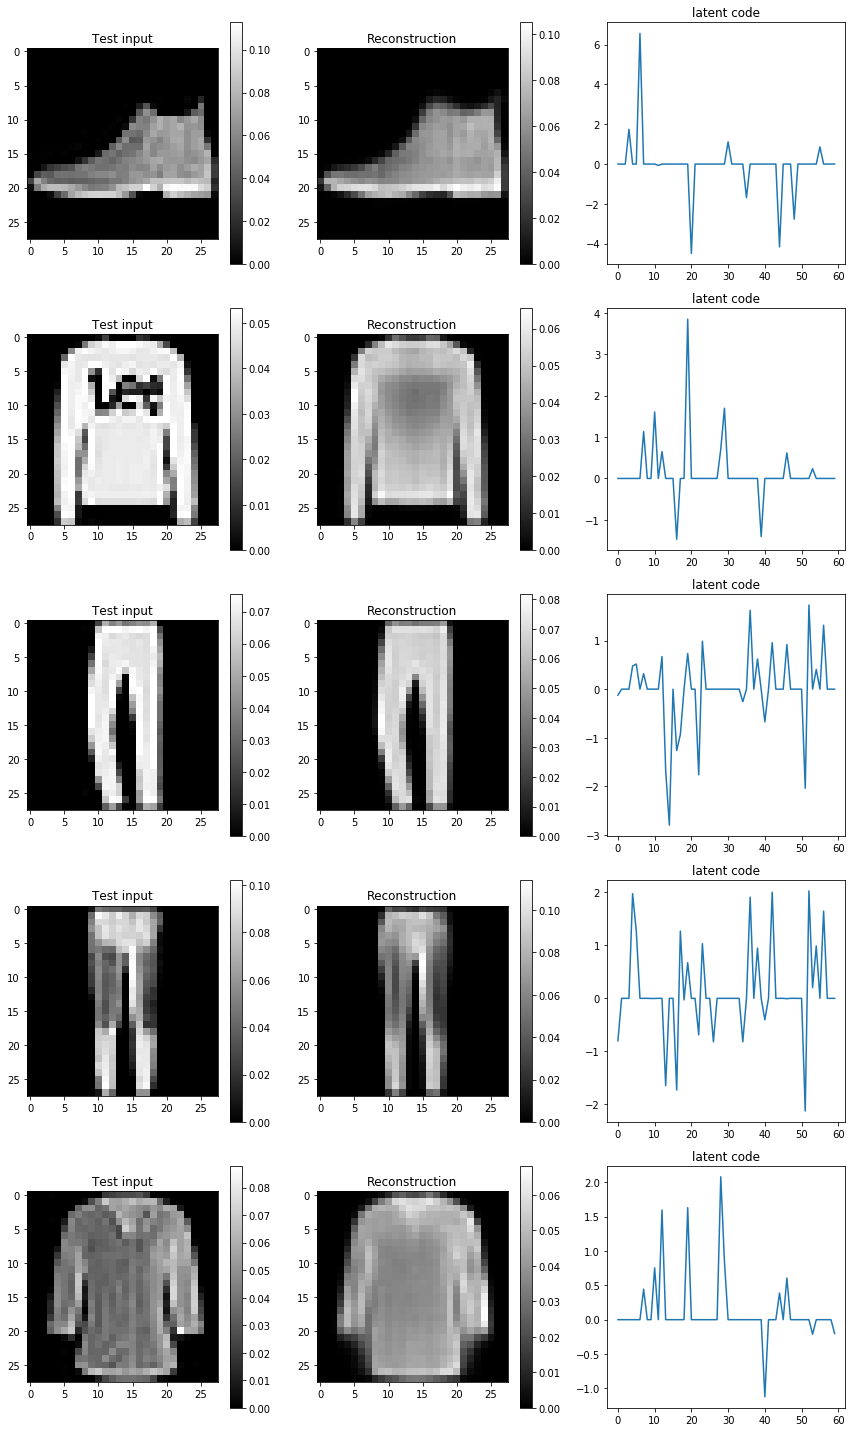

In [10]:
num_plots = 5
plt.figure(figsize=(20, 20))
for i in range(num_plots):
    
    plt.subplot(num_plots, 5, 5 * i + 1)
    plt.imshow(x_data_test[i].reshape(28, 28), cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    
    plt.subplot(num_plots, 5, 5 * i + 2)
    plt.imshow(mu_x[i].reshape(28, 28), cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    
    plt.subplot(num_plots, 5, 5 * i + 3)
    plt.plot(z[i])
    plt.title("latent code")
    
plt.tight_layout()
plt.show()